In [1]:
# Import necessary libraries
import os
import yfinance as yf
import pandas as pd
import numpy as np
import boto3
from io import BytesIO, StringIO
from datetime import datetime, timedelta
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import access_keys

# AWS Credentials and S3 setup
access_key = access_keys.access_key
secret_access_key = access_keys.secret_access_key
AWS_ACCESS_KEY_ID = access_key
AWS_SECRET_ACCESS_KEY = secret_access_key
bucket_name = "investment-plans"

#stock_data_folder = "Stock-Data"
#volatility_folder = "Volatility"

stock_data_folder = "Dow-Jones/Stock-Data"
volatility_folder = "Dow-Jones/Volatility"
model_directory = 'Dow-Jones/Models'

s3_client = boto3.client('s3', region_name='eu-west-2',
                         aws_access_key_id=AWS_ACCESS_KEY_ID,
                         aws_secret_access_key=AWS_SECRET_ACCESS_KEY)
location = {'LocationConstraint': 'eu-west-2'}

# Load Vanguard weights
#s3_vanguard_weights_key = 'Vanguard/vanguard_weights.csv'
#obj = s3_client.get_object(Bucket=bucket_name, Key=s3_vanguard_weights_key)
#holdings_df = pd.read_csv(BytesIO(obj['Body'].read()))

# Load Initial weights
s3_weights_key = 'Dow-Jones/DJIA.csv'
# Get the CSV file from S3 and read it with specified encoding

obj = s3_client.get_object(Bucket=bucket_name, Key=s3_weights_key)
holdings_df = pd.read_csv(BytesIO(obj['Body'].read()))
holdings_df['Weights'] = holdings_df['Weights'].apply(lambda x: float(str(x).strip('%')) / 100)
tickers = holdings_df['Ticker'].tolist()
# Normalize the weights so that they sum to 1
total_weight = holdings_df['Weights'].sum()
weights = holdings_df['Weights'] / total_weight

sectors = holdings_df['Sector'].tolist()  # Assuming the sector data is included in the weights CSV

holdings = dict(zip(tickers, weights))

sector_map = dict(zip(tickers, sectors))  # Map each ticker to its sector
#print(sector_map)
holdings = dict(sorted(holdings.items()))

# Load stock data
data = {}
response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=stock_data_folder)
for item in response.get('Contents', []):
    if item['Key'].endswith('.csv') and 'DJIA.csv' not in item['Key']:
        ticker = item['Key'].split('/')[-1].split('.')[0]
        obj = s3_client.get_object(Bucket=bucket_name, Key=item['Key'])
        df = pd.read_csv(BytesIO(obj['Body'].read()), index_col='Date', dayfirst=True, parse_dates=True)
        if len(df) >= 180:
            data[ticker] = df

# Load EWMA volatilities
volatility_key = f"{volatility_folder}/ewma_volatilities.csv"
volatility_obj = s3_client.get_object(Bucket=bucket_name, Key=volatility_key)
ewma_volatilities_df = pd.read_csv(BytesIO(volatility_obj['Body'].read()), index_col='Ticker')

# Convert EWMA volatilities to a dictionary
ewma_volatilities = ewma_volatilities_df['EWMA_Volatility'].to_dict()

# Ensure tickers align across all datasets
common_tickers = set(data.keys()) & set(holdings.keys()) & set(ewma_volatilities.keys())

# Filter datasets to include only common tickers
data = {ticker: data[ticker] for ticker in common_tickers}
holdings = {ticker: holdings[ticker] for ticker in common_tickers}
ewma_volatilities = {ticker: ewma_volatilities[ticker] for ticker in common_tickers}

# Adjust the data to ensure all have the same length
min_length = min(len(df) for df in data.values())
for ticker in data.keys():
    data[ticker] = data[ticker].iloc[:min_length]

# Define the environment for stock trading
class StockTradingEnv(gym.Env):
    def __init__(self, data, customer_profile, initial_balance=100000, initial_allocation=None):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.initial_allocation = initial_allocation if initial_allocation else {ticker: 0 for ticker in data.keys()}
        self.initial_portfolio = {ticker: 0 for ticker in data.keys()}
        self.investor_type = customer_profile["investor_type"]
        self.risk_level = customer_profile["risk_level"]
        self.current_step = 0
        self.done = False
        self.num_stocks = len(data)
        self.action_frequency = self._determine_action_frequency()
        self.volatility_threshold = self._determine_volatility_threshold()
        self.volatilities = ewma_volatilities
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.num_stocks,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(self.num_stocks * 2 + 1,), dtype=np.float32)
        self.reset()

    def calculate_initial_portfolio(self):
        portfolio = {}
        remaining_balance = self.initial_balance
        total_invested = 0  # Track the total invested amount
        latest_prices = {ticker: self.data[ticker]['Close'].iloc[self.current_step] for ticker in self.initial_allocation.keys()}
        
        for ticker, weight in self.initial_allocation.items():
            if ticker in latest_prices:
                allocated_amount = self.initial_balance * weight
                stock_price = latest_prices[ticker]
                num_shares = allocated_amount / stock_price
                if num_shares >= 0:
                    portfolio[ticker] = num_shares
                    cost = num_shares * stock_price
                    remaining_balance -= cost
                    total_invested += cost
        non_zero_weight_tickers = [ticker for ticker, shares in portfolio.items() if shares > 0]
        if non_zero_weight_tickers:
            while remaining_balance > 0:
                split_amount = remaining_balance / len(non_zero_weight_tickers)
                for ticker in non_zero_weight_tickers:
                    stock_price = latest_prices[ticker]
                    num_shares = split_amount/stock_price
                    portfolio[ticker] += num_shares
                    cost = num_shares * stock_price
                    remaining_balance -= cost
                    total_invested += cost

       
        # Print or log the invested amount and remaining balance
        #print(f"Total Invested: ${total_invested}")
        #print(f"Remaining Balance: ${remaining_balance}")
        
        return portfolio, remaining_balance

    
    def _determine_volatility_threshold(self):
        if self.risk_level == "low":
            return 0.5
        elif self.risk_level == "medium":
            return 0.6
        elif self.risk_level == "high":
            return 1
    
    def _determine_action_frequency(self):
        if self.investor_type == "extremely active":
            return 1
        elif self.investor_type == "highly active":
            return 7
        elif self.investor_type == "active":
            return 30
        elif self.investor_type == "passive":
            return 60

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.portfolio = self.initial_portfolio.copy()
        self.current_step = 0
        self.done = False
        return self._next_observation(), {}
    
    def _next_observation(self):
        prices = np.array([self.data[ticker]['Adj Close'].iloc[self.current_step] for ticker in self.data.keys()])
        prices = prices.flatten()  # Flatten the prices array if it's 2D
        portfolio_values = np.array(list(self.portfolio.values()))
        obs = np.concatenate(([self.balance], prices, portfolio_values))
        #print(obs)
        return obs


    def step(self, action):
        if self.current_step == 0:
            self.portfolio, self.balance = self.calculate_initial_portfolio()
        elif self.current_step % self.action_frequency == 0:
            prices = np.array([self.data[ticker]['Close'].iloc[self.current_step] for ticker in self.data.keys()])
            for i, ticker in enumerate(self.data.keys()):
                if action[i] > 0:
                    self._buy_stock(ticker, action[i], prices[i])
                elif action[i] < 0:
                    self._sell_stock(ticker, -action[i], prices[i])
        self.current_step += 1
        if self.current_step >= len(self.data[list(self.data.keys())[0]]) - 1:
            self.done = True
        reward = self._calculate_reward()
        return self._next_observation(), reward, self.done, False, {}

    def _calculate_reward(self):
        prices = np.array([self.data[ticker]['Adj Close'].iloc[self.current_step] for ticker in self.data.keys()])
        portfolio_value = sum(self.portfolio[ticker] * prices[i] for i, ticker in enumerate(self.portfolio.keys()))
        total_value = self.balance + portfolio_value
        reward = total_value - self.initial_balance
        return reward

    def _buy_stock(self, ticker, amount, price):
        if self.balance >= amount * price and self.volatilities[ticker] <= self.volatility_threshold:
            self.balance -= amount * price
            self.portfolio[ticker] += amount
    
    def _sell_stock(self, ticker, amount, price):
        if self.portfolio[ticker] >= amount and self.volatilities[ticker] <= self.volatility_threshold:
            self.balance += amount * price
            self.portfolio[ticker] -= amount


In [2]:
customer_profiles = {
    "low_risk_passive": {"risk_level": "low", "investor_type": "passive"},
    "low_risk_active": {"risk_level": "low", "investor_type": "active"},
    "low_risk_highly_active": {"risk_level": "low", "investor_type": "highly active"},
    "low_risk_extremely_active": {"risk_level": "low", "investor_type": "extremely active"},
    
    "medium_risk_passive": {"risk_level": "medium", "investor_type": "passive"},
    "medium_risk_active": {"risk_level": "medium", "investor_type": "active"},
    "medium_risk_highly_active": {"risk_level": "medium", "investor_type": "highly active"},
    "medium_risk_extremely_active": {"risk_level": "medium", "investor_type": "extremely active"},
    
    "high_risk_passive": {"risk_level": "high", "investor_type": "passive"},
    "high_risk_active": {"risk_level": "high", "investor_type": "active"},
    "high_risk_highly_active": {"risk_level": "high", "investor_type": "highly active"},
    "high_risk_extremely_active": {"risk_level": "high", "investor_type": "extremely active"}
}



def create_initial_allocation(data, holdings, volatilities, risk_level):
    
    initial_allocation = {ticker: 0 for ticker in data.keys()}
    tickers_in_data = set(data.keys())
    
    for ticker, weight in holdings.items():
        if ticker in tickers_in_data:
            if risk_level == "low":
                if volatilities[ticker] <= 0.4:
                    initial_allocation[ticker] = weight
            elif risk_level == "medium":
                if volatilities[ticker] <= 0.6:
                    initial_allocation[ticker] = weight
            elif risk_level == "high":
                initial_allocation[ticker] = weight
    return initial_allocation

trained_models = {}

for profile_name, profile in customer_profiles.items():
    initial_allocation = create_initial_allocation(data, holdings, ewma_volatilities, profile['risk_level'])  # or "high"
    
    env = StockTradingEnv(data, customer_profile=profile, initial_balance=100000, initial_allocation=initial_allocation)   
    vec_env = make_vec_env(lambda: env, n_envs=1)

    model = PPO("MlpPolicy", vec_env, verbose=1)
    model.learn(total_timesteps=10000)
    
    model_buffer = BytesIO()
    model.save(model_buffer)
    model_buffer.seek(0)
    
    s3_model_key = f"{model_directory}/ppo_stock_trading_{profile_name}.zip"
    s3_client.put_object(Bucket=bucket_name, Key=s3_model_key, Body=model_buffer.getvalue())
    print(f"Model for {profile_name} saved to s3://{bucket_name}/{s3_model_key}")
    
    trained_models[profile_name] = model
    

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 250      |
|    ep_rew_mean     | 3.06e+06 |
| time/              |          |
|    fps             | 1093     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 250           |
|    ep_rew_mean          | 3.06e+06      |
| time/                   |               |
|    fps                  | 637           |
|    iterations           | 2             |
|    time_elapsed         | 6             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 3.0290685e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -42.6         |
|    explained_variance   |

In [3]:
# List of tickers in the Dow Jones Industrial Average
dow_jones_tickers = [
    "AAPL", "AMGN", "AMZN", "AXP", "BA", "CAT", "CRM", "CSCO", "CVX", "DIS", "DOW",
    "GS", "HD", "HON", "IBM", "INTC", "JNJ", "JPM", "KO", "MCD", "MMM",
    "MRK", "MSFT", "NKE", "PG", "TRV", "UNH", "V", "VZ", "WBA", "WMT"
]

# Create a dictionary to store the sectors for each ticker
ticker_sectors = {}

# Loop through each ticker to fetch its sector
for ticker in dow_jones_tickers:
    stock = yf.Ticker(ticker)
    stock_info = stock.info
    sector = stock_info.get('sector', 'Unknown')  # Retrieve the sector or 'Unknown' if not available
    ticker_sectors[ticker] = sector

252
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[100000.0]
LENGTH
251
Gainers and Losers data for low_risk_passive saved to s3://investment-plans/Dow-Jones/Results/low-risk/gainers_losers_low_risk_passive.json
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[100000.0]
LENGTH
251
Gainers and Losers data for low_risk_active saved to s3://investment-plans/Dow-Jones/Results/low-risk/gainers_losers_low_risk_active.json
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[100000.0]
LENGTH
251
Gainers and Losers data for low_risk_highly_active saved to s3://investment-plans/Dow-Jones/Results/low-risk/gainers_losers_low_risk_highly_active.json
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[100000.0]
LENGTH
251
Gainers and Losers data for low_risk_extremely_active saved to s3://investment-plans/Dow-Jones/Results/low-risk/gainers_losers_low_risk_extremely_active.json
Wrapping the

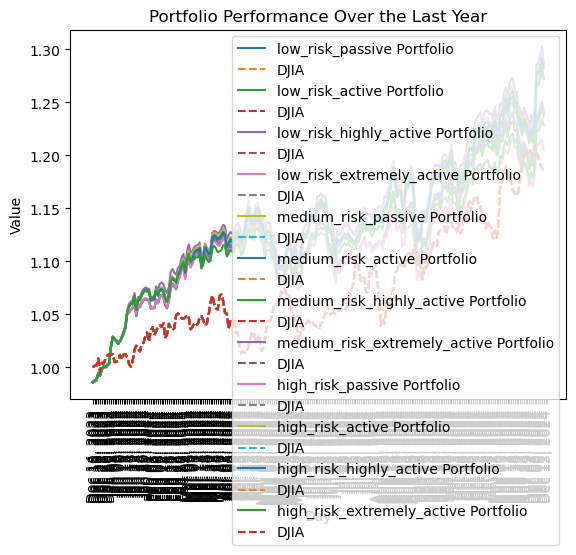

In [4]:
initial_investment = 100000

# Directories for results based on risk levels
results_directories = {
    'low': 'Dow-Jones/Results/low-risk',
    'medium': 'Dow-Jones/Results/medium-risk',
    'high': 'Dow-Jones/Results/high-risk'
}

# Define the periods to check (in trading days)
periods = {
    '1m': 20,   # Approximately 1 month
    '3m': 60,   # Approximately 3 months
    '6m': 120,  # Approximately 6 months
    '1y': 250   # Approximately 1 year
}

# Download DJIA data
djia = yf.Ticker("^DJI")
djia_data = djia.history(period="1y")

# Generate day labels from the index
day_labels = djia_data.index.strftime('%b %d, %Y').tolist()

# Normalize DJIA investment values to start with 1 (representing a $1 investment)
djia_investment_values = [value / djia_data['Close'].iloc[0] for value in djia_data['Close']]
print(len(djia_investment_values))

# Prepare results structure
results = {}
average_portfolio_values = {profile_name: 0 for profile_name in customer_profiles.keys()}

# Loop through customer profiles
for profile_name, profile in customer_profiles.items():
    # Initialize environment
    initial_allocation = create_initial_allocation(data, holdings, ewma_volatilities, profile['risk_level'])
    env = StockTradingEnv(data, customer_profile=profile, initial_balance=initial_investment, initial_allocation=initial_allocation)
    
    # Load model
    model_key = f"{model_directory}/ppo_stock_trading_{profile_name}.zip"
    model_buffer = BytesIO(s3_client.get_object(Bucket=bucket_name, Key=model_key)['Body'].read())
    model = PPO.load(model_buffer, env=env)
    
    # Run simulation
    obs, info = env.reset()
    daily_portfolio_values = [env.balance + sum([env.portfolio[ticker] * env.data[ticker]['Adj Close'].iloc[env.current_step] for ticker in env.data.keys()])]
    print(daily_portfolio_values)
    performance_data = []
    for step in range(len(env.data[list(env.data.keys())[0]])):
        action, _states = model.predict(obs)
        obs, rewards, done, truncated, info = env.step(action)
        portfolio_value = env.balance + sum([env.portfolio[ticker] * env.data[ticker]['Adj Close'].iloc[env.current_step] for ticker in env.data.keys()])
        daily_portfolio_values.append(portfolio_value)
        djia_value = djia_investment_values[step]
        #print(daily_portfolio_values)
        #print(djia_value)
        timestamp = day_labels[step]
        
        # Add a tuple (timestamp, portfolio value, DJIA value) to performance data
        performance_data.append((timestamp, portfolio_value/initial_investment, djia_value))
        
        if done or truncated:
            break
    print("LENGTH")
    print(len(daily_portfolio_values))
    final_portfolio_value = env.balance + sum([env.portfolio[ticker] * env.data[ticker]['Adj Close'].iloc[env.current_step] for ticker in env.data.keys()])
    average_portfolio_values[profile_name] += final_portfolio_value
    
    # Calculate sector breakdown
    sector_values = {}
    for ticker, shares in env.portfolio.items():
        # Get the sector for the current ticker from ticker_sectors
        sector = ticker_sectors.get(ticker, 'Unknown')  # Default to 'Unknown' if the sector is not found
        if sector not in sector_values:
            sector_values[sector] = 0
    
    # Calculate the total value for the sector based on the number of shares and the current adjusted close price
    sector_values[sector] += shares * env.data[ticker]['Adj Close'].iloc[env.current_step]
    sector_breakdown = {sector: value / final_portfolio_value for sector, value in sector_values.items()}

    # Extract the 10 largest holdings in the portfolio by percentage
    portfolio_total_value = sum([env.portfolio[ticker] * env.data[ticker]['Adj Close'].iloc[env.current_step] for ticker in env.portfolio.keys()])
    major_holdings = sorted(
        [{'stockName': ticker, 'percentage': (env.portfolio[ticker] * env.data[ticker]['Adj Close'].iloc[env.current_step]) / portfolio_total_value}
         for ticker in env.portfolio.keys()],
        key=lambda x: x['percentage'],
        reverse=True
    )[:10]

    # Store results
    if profile_name not in results:
        results[profile_name] = {
            'expectedAnnualReturn': 0,
            'fees': 100,  # This will be normalized later
            'finalPortfolioValue': 0,
            'majorHoldings': major_holdings,
            'portfolio': [],
            'sectorBreakdown': sector_breakdown,
            'performanceData': performance_data  # New data structure combining timestamp, portfolio value, and DJIA value
        }


    for ticker in env.portfolio.keys():
        ticker_value = env.portfolio[ticker] * env.data[ticker]['Adj Close'].iloc[env.current_step]
        ticker_proportion = ticker_value / portfolio_total_value  # Proportion of the ticker in the portfolio
        temp = {
            'stockTicker': ticker,
            'noShares': env.portfolio[ticker],
            'proportion': ticker_proportion  # Add the proportion
        }
        results[profile_name]['portfolio'].append(temp)

    
    #results[profile_name]['portfolioValues'] = daily_portfolio_values
    results[profile_name]['sectorBreakdown'] = sector_breakdown
    #results[profile_name]['djiaValues'] = djia_investment_values  # Update key to reflect DJIA

    # Calculate gainers and losers specific to the portfolio
    gainers_losers = {}
    for period_name, period_length in periods.items():
        gainers = []
        losers = []
    
        for ticker in env.portfolio.keys():
            # Calculate percentage change over the given period
            if period_length < len(env.data[ticker]):
                start_price = env.data[ticker]['Adj Close'].iloc[-period_length - 1]
                end_price = env.data[ticker]['Adj Close'].iloc[-1]
                percentage_change = ((end_price - start_price) / start_price) * 100
    
                stock_data = {
                    "StockName": ticker,
                    "Percentage": percentage_change
                }
    
                # Append to gainers or losers list
                if percentage_change > 0:
                    gainers.append(stock_data)
                else:
                    losers.append(stock_data)
    
        # Sort the gainers and losers lists by percentage change
        gainers = sorted(gainers, key=lambda x: x['Percentage'], reverse=True)
        losers = sorted(losers, key=lambda x: x['Percentage'])
    
        # Store the top 5 gainers and losers in the dictionary
        gainers_losers[f'gainers-{period_name}'] = gainers[:5]  # Top 5 gainers
        gainers_losers[f'losers-{period_name}'] = losers[:5]    # Top 5 losers
    
    # Convert the gainers_losers dictionary to JSON
    gainers_losers_json = json.dumps(gainers_losers, indent=4)
    
    # Define the S3 path for the gainers and losers file
    gainers_losers_s3_key = f"{results_directories[profile['risk_level']]}/gainers_losers_{profile_name}.json"
    
    # Upload the gainers_losers JSON to S3
    s3_client.put_object(Bucket=bucket_name, Key=gainers_losers_s3_key, Body=gainers_losers_json)
    print(f"Gainers and Losers data for {profile_name} saved to s3://{bucket_name}/{gainers_losers_s3_key}")

# Calculate average final values and expected annual returns
for profile_name in average_portfolio_values.keys():
    average_final_value = average_portfolio_values[profile_name]
    results[profile_name]['finalPortfolioValue'] = average_final_value

    total_return = average_final_value - initial_investment
    annual_return_percentage = (total_return / initial_investment) * 100
    results[profile_name]['expectedAnnualReturn'] = annual_return_percentage

# Normalize results before saving to S3
for profile_name, result in results.items():
    # Normalise portfolio values and final portfolio value
    #result['portfolioValues'] = [value / initial_investment for value in result['portfolioValues']]
    result['finalPortfolioValue'] /= initial_investment
    result['fees'] /= initial_investment  # Normalize the fees as well

    # Determine results directory based on risk level
    if "low" in profile_name:
        results_directory = results_directories['low']
    elif "medium" in profile_name:
        results_directory = results_directories['medium']
    elif "high" in profile_name:
        results_directory = results_directories['high']
    
    result_json = json.dumps(result, indent=4)
    s3_file_key = f"{results_directory}/portfolio_results_{profile_name}.json"
    s3_client.put_object(Bucket=bucket_name, Key=s3_file_key, Body=result_json)
    print(f"Results for {profile_name} saved to s3://{bucket_name}/{s3_file_key}")

    # Plot results
    timestamps, portfolio_values, djia_values = zip(*result['performanceData'])
    plt.plot(portfolio_values, label=f"{profile_name} Portfolio")
    plt.plot(djia_values, label="DJIA", linestyle='--')

# Set x-axis labels
plt.xticks(ticks=range(len(day_labels)), labels=day_labels, rotation=90)
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Portfolio Performance Over the Last Year')
plt.legend()
plt.show()

In [5]:
# Assuming the relevant results for 'low_risk_active' profile have already been generated
profile_name = 'low_risk_active'

# Extract the relevant information from the results dictionary for 'low_risk_active'
final_portfolio_value = results[profile_name]['finalPortfolioValue']
expected_annual_return = results[profile_name]['expectedAnnualReturn']
performance_data = results[profile_name]['performanceData']

# Prepare the data to be saved in the i_plan_performance_low_risk_active.json file
performance_json_data = {
    "finalPortfolioValue": final_portfolio_value,
    "expectedAnnualReturn": expected_annual_return,
    "performanceData": performance_data
}

# Convert the data to JSON format
performance_json = json.dumps(performance_json_data, indent=4)

# Define the S3 key (path) for the performance JSON file
performance_s3_key = "i_plan_performance_low_risk_active.json"

# Upload the performance JSON file to the 'investment-plan-performance' bucket
s3_client.put_object(Bucket='investment-plan-performance', Key=performance_s3_key, Body=performance_json)
print(f"Performance data for {profile_name} saved to s3://investment-plan-performance/{performance_s3_key}")

# Assuming the gainers_losers dictionary has already been generated for 'low_risk_active'
gainers_losers_s3_key = "gainers_losers_low_risk_active.json"

# Convert the gainers_losers data to JSON format
gainers_losers_json = json.dumps(gainers_losers, indent=4)

# Upload the gainers and losers JSON file to the same bucket
s3_client.put_object(Bucket='investment-plan-performance', Key=gainers_losers_s3_key, Body=gainers_losers_json)
print(f"Gainers and Losers data for {profile_name} saved to s3://investment-plan-performance/{gainers_losers_s3_key}")

Performance data for low_risk_active saved to s3://investment-plan-performance/i_plan_performance_low_risk_active.json
Gainers and Losers data for low_risk_active saved to s3://investment-plan-performance/gainers_losers_low_risk_active.json


In [6]:
data

{'NKE':              Adj Close       Close        High         Low        Open  \
 Date                                                                     
 2023-11-14  104.146599  105.750000  107.099998  105.379997  105.559998   
 2023-11-15  106.185211  107.820000  109.059998  106.720001  106.820000   
 2023-11-16  105.978401  107.610001  108.000000  107.000000  107.099998   
 2023-11-17  104.353416  105.959999  108.209999  105.519997  108.059998   
 2023-11-20  104.707954  106.320000  106.550003  105.099998  106.000000   
 ...                ...         ...         ...         ...         ...   
 2024-11-06   75.320000   75.320000   76.949997   75.120003   76.870003   
 2024-11-07   75.919998   75.919998   76.370003   75.209999   75.699997   
 2024-11-08   75.879997   75.879997   76.559998   75.250000   75.500000   
 2024-11-11   76.599998   76.599998   77.400002   76.099998   76.150002   
 2024-11-12   76.660004   76.660004   77.430000   76.139999   76.459999   
 
               V

In [7]:
#pip install yfinance --upgrade